<a href="https://colab.research.google.com/github/vladop22/PRA3024-Analysis-of-Big-Data-in-Physics/blob/main/V_Pehar_ML_gym_reinforcement_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB = True

if(COLAB) :
  # install some helpers to visualize gym graphics in the colab environment
  !pip install gym==0.22
  !pip install pyvirtualdisplay
  !pip install imageio-ffmpeg
  !pip install moviepy==1.0.3
  !pip install pygame
  !apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 KB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708393 sha256=6621e4ae1c049b6cf23689d679d6506b1bdf6af65e74d8963d63246195bc8a1f
  Stored in directory: /root/.cache/pip/wheels/c4/15/15/94c62e06887fb88768c5fa41482b80905ea71f3ede81040ffa
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 40.1 MB/s

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [3]:
# only necessary for visualisation in colab env.
if(COLAB) :
  from IPython.display import HTML
  from IPython import display as ipythondisplay
  from pyvirtualdisplay import Display
  from gym.wrappers import Monitor
  import glob, io, os, base64
  from moviepy.editor import VideoFileClip, concatenate_videoclips

  display = Display(visible=0, size=(1400, 900))
  display.start()
  #os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

  def combine_videos() :
    mp4list = sorted( glob.glob('video/*.mp4') )
    if len(mp4list) > 0 :
      videolist = []
      for mp4 in mp4list :
        videolist.append( VideoFileClip(mp4))
      final_clip = concatenate_videoclips(videolist)
      final_clip.to_videofile("combined.mp4", fps=24, remove_temp=False)
      return 1
    else :
      return 0

  def show_video() :
      if(combine_videos()) :
        video = io.open("combined.mp4", 'r+b').read()

        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded.decode('ascii'))))
      else :
        print("Error: no videos found")     


  def wrap_env(env):
    env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True)
    return env


In [4]:
ENV_NAME = "CartPole-v1"

MAXRUNS = 10

GAMMA = 0.80  # 'future discount factor'
LEARNING_RATE = 0.001 # rate at which to update weights after each training step

MEMORY_SIZE = 500 # size of container to hold actions and outcomes
BATCH_SIZE = 40 # number of actions in memory to 'replay' after each death

# probability to do 'random' actions, to sample from event space
EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.001
EXPLORATION_DECAY = 0.995   # 0.995 --> 1% after ~35 runs

RANDOM_TRUE = True 
RANDOM_EVERY = 200
# RANDOM_TRUE is used to avoid local minima. However, within the colab environment, my RAM tend to crash so I set it to False.
# RANDOM_EVERY takes a random action every 200 'episodes'given that RANDOM_TRUE is set to True. 


In [5]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        # This will be a simple feed-forward NN, with 
        #  - input = 'observation' (aka state)
        #  - output = predicted 'quality' of each possible action
        self.model = Sequential() 
        #Below, we defined a Sequential model with 3 layers. The first and the second layer consist of 24 and 12 units, respectively. 
        #Third layer corresponds to the number of actions the agent can take in this environment (2).

        self.model.add(Dense(24, input_shape=(observation_space,), activation = "relu", kernel_initializer='he_uniform')) 
        #using relu activation and initializer 'he_uniform'
        self.model.add(Dense(12, activation = "relu", kernel_initializer='he_uniform'))
        self.model.add(Dense(self.action_space, activation="relu", kernel_initializer='he_uniform'))

        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))
        self.model.summary()
        
    def remember(self, state, action, reward, next_state, done):
        # add event to memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # return the best possible action for the current state

        # sometimes allow for a random action at the 'exploration rate', to avoid local minima
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        
        # Get predicted qualities for each possible action, and return the action (=index) with the highest quality
        q_values = self.model.predict(state) 
        return np.argmax(q_values[0])

    def experience_replay(self):
        # Learn from random subset of memory (reduces corr. between subsequent actions).
        # learning is done by comparing 'predicted quality' to the here defined quality (~reward) of the action.
        
        if len(self.memory) < BATCH_SIZE:
            # We haven't experienced enough to properly learn yet - keep exploring!
            return
        
        # Get random subset of memory
        batch = random.sample(self.memory, BATCH_SIZE) 
        
        for state, action, reward, state_next, terminal in batch:

            # We define the 'quality' of a move by taking the known, memorized reward for the action,
            #  and adding the predicted quality of the (predicted) best choice of action for the next state, to that.
            # As the model learns to give this situation a low quality, any step leading up to this state will get a 
            #  lower quality due to the predict(state_next) term. This will slowly trickle through to the step before that, etc.,
            #  slowly making our agent learn about future consequences of current actions.
          
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                
            # - Define the quality of the non-chosen action to just be the predicted quality (i.e. diff = 0)
            # - Define the quality of the chosen action to be the newly defined quality
            q_values = self.model.predict(state)
            q_values[0][action] = q_update 
            
            # Finally, find the optimal model weights for minimal difference between 
            #  predicted quality and observed quality (+ future prediction as per above) for this action.
            # The weights are then updated * learning rate
            self.model.fit(state, q_values, verbose=0) 
            
        # reduce the 'random choices' rate over time, because you expect the model to have learned
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [6]:
def cartpole() :
    if(COLAB) : env = wrap_env(gym.make(ENV_NAME)) # only for visualisation in colab
    else : env = gym.make(ENV_NAME)

    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
       
    run=0
    runsteplog = []
    random_count = 0
    
    for i in range(MAXRUNS):
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        
        while True :    
            step += 1
            screen = env.render() # graphical output

            if (RANDOM_TRUE and random_count ==RANDOM_EVERY):
              action=env.action_space.sample()
              random_count=0
            else:
              action = dqn_solver.act(state)
              if (RANDOM_TRUE):
                random_count+=1

            state_next, reward, terminal, info = env.step(action) 

            # if action made terminal: reduce reward!
            reward = reward if not terminal else -reward  

            state_next = np.reshape(state_next, [1, observation_space])

            # fill agent memory with this action's results
            dqn_solver.remember(state, action, reward, state_next, terminal) 

            # prepare for the next action in the environment
            state = state_next 
            
            if terminal :
                #state = env.reset()
                #state = np.reshape(state, [1, observation_space])
                print("Run: {0}, exploration: {1:.15f}, score: {2}".format(run,dqn_solver.exploration_rate,step))
                runsteplog += [step]

                break
            
            dqn_solver.experience_replay() # learn from batch of memories every time a new one is made


    env.close()
    
    # plot #steps achieved
    plt.plot(runsteplog)
    plt.ylabel("# actions before terminal")
    plt.xlabel("run iteration")

    success_measure = np.mean(runsteplog[-15:])
    print("Mean of last 15 runs: {0}".format(success_measure))
    return success_measure

  super().__init__(name, **kwargs)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
Run: 7, exploration: 0.567555222460375, score: 25
1/1 [==============================] - 0s 33ms/step
Run: 8, exploration: 0.498205162714624, score: 27
1/1 [==============================] - 0s 29ms/step
Run: 9, exploration: 0.476229122922841, score: 10
1/1 [==============================] - 0s 31ms/step
Run: 10, exploration: 0.424372084062810, score: 24
Mean of last 15 runs: 21.9
Moviepy - Building video combined.mp4.
Moviepy - Writing video combined.mp4



Moviepy - Done !
Moviepy - video ready combined.mp4


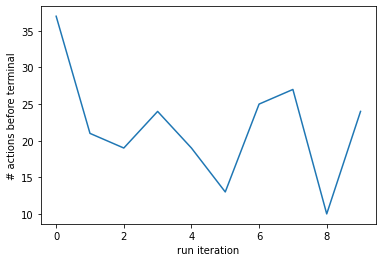

In [7]:
MAXRUNS = 10

if __name__ == "__main__":
    cartpole()

if(COLAB) :
    show_video() 

Although the final code was changed from the more general setup as illustrated below, this setup yielded the best results. After approximately 15 runs, we reached a max of 60-70 actions before termination. As can be observed from the plot below, after reaching the peak, the number of actions drastically drop with consecutive runs after, implying that the system is not 'learning' anything knew. Perhaps, we reached some sort of a threshold with the parameters and functions as they were defined intially. 

MAXRUNS = 30,
GAMMA = 0.95,
LEARNING_RATE = 0.001  

MEMORY_SIZE = 500 
BATCH_SIZE = 20 

EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.001

EXPLORATION_DECAY = 0.995  
        self.model.add(Dense(24, input_shape=(observation_space,), activation = "relu"))
        self.model.add(Dense(24, activation = "relu"))
        self.model.add(Dense(self.action_space, activation="relu"))

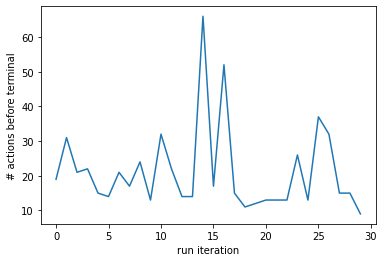

However, the final code should be more optimal for use in this task. Due to several crashings of the RAM memory after the code ran for 45 minutes to an hour, I was not able to produce a graph showing a positive correlation between no. of actions and runs. Still, I was able to achieve up to 90 actions around 15-18 runs before the code were to crash. I believe that is an indicator of the better working method as written out in the 3-layer functionality of the system that uses relu activation and he-uniform initialization, commonly used in deep/machine learning. The final code is limited to 10 runs, since it ensured it would complete without crashing. 

RANDOM MOVES

Use of random moves was incorporated within the working code. However, due to the ram limitations, I was not able to run it long without crashing. 

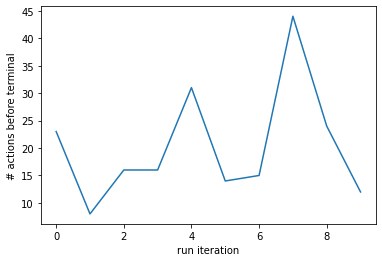

Still, the image above shows the first 10 runs of the code using the random moves method and shows that generally, there is an increase in number of actions with increase in the number of run. Setting the randomm-move parameter as low as possible would optimize the learning further, but by setting it anywhere lower than 100 hundred, the RAM crashed around 6-8 run. Still, in the final code presented, lower batch size was used since the running time exceeded 45 minutes on average, so repeating the runs with slightly different parameters took a long time. Therefore, I lowered the parameters to be able to show some results using the code I believe would be a better learning method than the code used to obtain the best result as shown in the first plot. On a side note, we would ideally increase the batch and memory size as well as the learning rate of the system, and then we could compare the outcomes to determine at which point does the machine 'over-learns' and therefore, does not yield the most optimal results. 
